# Simulation Study: Closed System
 Simulate 50 batches of 5 donors who experience the same Q. Use optimisation of procedure to derive the point estimates for the parameters of the Q governing the system.

In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_temptations_functions import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial

import pickle

In [2]:
planting(456)

In [3]:
# set system wide param
k = 7 # no. of states
timeCourse = 16 # total timepoints
u = [1] * int(timeCourse) # time interval
n_param = int(k/2 * (k-1)) # number of parameters

sampRange_ub = 4
xterm = 1e-15
max_iter = 5e3
numCores = 5
mc_iter = 5

In [4]:
filename = "simResults/simulated_CN_Q_true.pkl"
with open(filename, 'rb') as f:
   Q_true = pickle.load(f)

In [4]:
startCount = 10**6 # no. in initial system
N0 = createN0(k, startCount, )
Q_true = make_theta0(k, 'Q')

# closed system w\ noise
simCN_df = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=False, timeCount=0, timeMarker='d', noise=True)
simCN = simCN_df.to_numpy()

In [5]:
filename = "simDatasets/simulated_CN_dataframe.pkl"
with open(filename, 'wb') as f:
    pickle.dump(simCN_df, f)

### Estimation

In [5]:
# set variables
pi_hat, T = eqTin(simCN)

Q_template = make_theta0(k, 'Q')

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

In [6]:
# estimate
optimiserArgs = {'costFunc': calc_cost, 'args': (pi_hat, T, k, u, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub}
options = {'hessian': None, 'xterm': xterm, 'max_iter': max_iter}

closedNoise_theta, closedNoise_optError = parallel_mc_optimiser(mc_iter, numCores, n_param, optimiserArgs = optimiserArgs, options = options, progress_bar=True)

  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 20% (1 of 5) |#####                     | Elapsed Time: 0:02:43 ETA:   0:10:55
 40% (2 of 5) |##########                | Elapsed Time: 0:04:28 ETA:   0:05:13
 60% (3 of 5) |###############           | Elapsed Time: 0:05:10 ETA:   0:01:23
 80% (4 of 5) |####################      | Elapsed Time: 0:06:07 ETA:   0:00:57
100% (5 of 5) |##########################| Elapsed Time: 0:06:09 ETA:  00:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:06:09 Time:  0:06:09


In [7]:
closedNoise_theta - Q_true[Q_true[:,:-1].nonzero()]

array([-5.41890197e-05,  5.54998844e-05, -1.53395352e-04,  3.56864441e-03,
        1.70452240e-03, -5.32940390e-03,  2.47019078e-05,  7.79477305e-04,
       -1.48882294e-02, -7.21296981e-03,  2.21786580e-02, -1.36349305e-03,
        1.44143469e-02, -1.22099311e-02, -2.46324033e-03,  7.71639214e-03,
        2.21917702e-02, -2.95245229e-02, -3.57793045e-03,  3.42883206e-03,
       -3.67985739e-05])

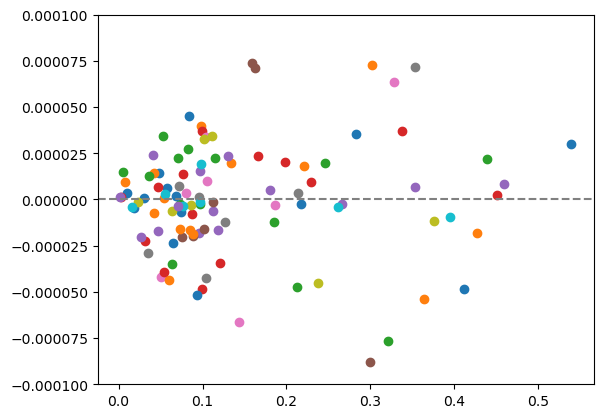

Average abs. residual:  2.1974350735149596e-05


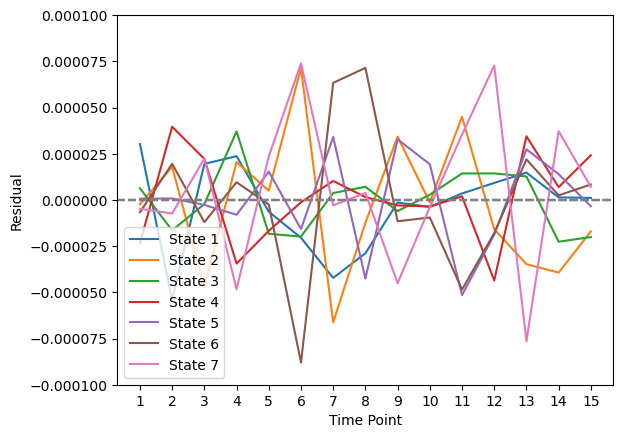

In [8]:
# residuals
new = closedNoise_theta
S1_Q = theta_to_Q(new, k,Q_template)

state_list = ['State ' + str(i) for i in range(1,k+1)]

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),pi_hat[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - pi_hat[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-1e-4,1e-4)
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = state_list[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-1e-4,1e-4)

        
print("Average abs. residual: ", np.mean(abs(epsi)))

Make loop with 50 iterations for creating multiple donors.

In [5]:
def create_multiDonor_simData(i, donorGroupSize = 5, Q = Q_true, timeCourse = 16):
    planting(i)
    
    startCount = 10**6
    u = [1] * int(timeCourse) # time interval
    
    pi_hat_donors = {}
    T_donors = {}
    u_donors = {}

    donor_list = ['donor_' + str(i) for i in range(1, donorGroupSize+1)]

    for d in donor_list:
        N0 = createN0(k, startCount)
        donor = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=False, timeCount=0, timeMarker='d', noise=True)
        donor = donor.to_numpy()
        pi_hat, T = eqTin(donor)
        
        pi_hat_donors[d] = pi_hat
        T_donors[d] = T
        u_donors[d] = u

    return pi_hat_donors, T_donors, u_donors

def sim_loop_perDonor_estimate(donorGroupSize = 5, replicates = 50, Q = Q_true, timeCourse = 16):

    k = Q_true.shape[0]
    Q_template = make_theta0(k, 'Q')
    n_param = len(Q_template[:,:-1].nonzero()[0])
    
    reg_bounds = def_bounds(n_param, k, account_ingress=False)
    reg_con = def_constraints(n_param, k)
    
    # initialise estimate dictionary to save to.
    estimated_theta = np.empty((replicates,n_param))
    estimated_cost = np.empty(replicates)

    # def. filenames for saving out data during run
    file_data = "simDatasets/simulated_CN_propDicts_groupSize5.pkl"
    file_result = "simResults/simulated_CN_estimates_50reps.pkl"
     
    optimiserArgs = {'costFunc': calc_cost_donors, 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 4}
    options = {'hessian': None, 'xterm': 1e-15, 'max_iter': 1e4}

    # track progress
    i=0
    bar = progressbar.ProgressBar(maxval=replicates, \
    widgets=['Simulation progress:',' ',progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    startIteration = 0
    for rep in range(startIteration,replicates):

        # load file if not starting from first replicate.
        if rep == startIteration:
            with open(file_result, 'rb') as f:
                [estimated_theta, estimated_cost] = pickle.load(f)
                        
        pi_hat_donors, T_donors, u_donors = create_multiDonor_simData(rep, donorGroupSize, Q, timeCourse)
        optimiserArgs['args'] = (pi_hat_donors, T_donors, k, u_donors, Q_template)
        
        # save first dataset
        if rep == 0:
            with open(file_data, 'wb') as f:
                pickle.dump([pi_hat_donors, T_donors, u_donors], f)
                
        # estimate
        theta_est, optError = parallel_mc_optimiser(5, 5, n_param, optimiserArgs=optimiserArgs, options=options, progress_bar=False)

        # save out
        estimated_theta[rep,:] = theta_est
        estimated_cost[rep] = optError
        
        with open(file_result, 'wb') as f:
                pickle.dump([estimated_theta, estimated_cost], f)

        i+=1
        bar.update(i)
    bar.finish()

In [6]:
# initialise estimate dictionary to save to.
estimated_theta = np.empty((50,n_param))
estimated_cost = np.empty(50)

with open("simResults/simulated_CN_estimates_50reps.pkl", 'wb') as f:
                pickle.dump([estimated_theta, estimated_cost], f)

In [7]:
sim_loop_perDonor_estimate()

Simulation progress: [                                                   ]   0%
Simulation progress: [=                                                  ]   2%
Simulation progress: [==                                                 ]   4%
Simulation progress: [===                                                ]   6%
Simulation progress: [====                                               ]   8%
Simulation progress: [=====                                              ]  10%
Simulation progress: [======                                             ]  12%
Simulation progress: [=======                                            ]  14%
Simulation progress: [========                                           ]  16%
Simulation progress: [=========                                          ]  18%
Simulation progress: [==========                                         ]  20%
Simulation progress: [===========                                        ]  22%
Simulation progress: [============      

In [8]:
filename = "simResults/simulated_CN_estimates_50reps.pkl"
with open(filename, 'rb') as f:
                [estimated_theta, estimated_cost] = pickle.load(f)